[View in Colaboratory](https://colab.research.google.com/github/yonghyeokrhee/yong/blob/master/Risk_Parity_Strategy_with_S&P500_9_sectors_ver3.ipynb)

# Risk Parity Strategy with S&P500 9 sectors

# 1. Import & Definition

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
import seaborn as sns
import datetime
import io

import statsmodels.api as sm
from scipy.optimize import minimize

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('darkgrid')

## 1.1 Data Import 

In [0]:
from google.colab import files

In [6]:
uploaded = files.upload()

Saving snp500_sector_etf_2000_2017_monthly_WRDS_ver2.csv to snp500_sector_etf_2000_2017_monthly_WRDS_ver2.csv


In [7]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "snp500_sector_etf_2000_2017_monthly_WRDS_ver2.csv" with length 200058 bytes


In [0]:
df_returns = pd.read_csv(io.StringIO(uploaded['snp500_sector_etf_2000_2017_monthly_WRDS_ver2.csv'].decode('utf-8')))

In [9]:
df_returns['date'] = '01' + df_returns['date'].str[2:]
df_returns.head()

,PERMNO,date,TICKER,COMNAM,CUSIP,HSICIG,PRC,RET,SHROUT,vwretd,ewretd
0,84398,01/01/2000,SPY,SPDR TRUST,78462F10,NaN,139.62500,-0.049362,27109,-0.039607,0.050642
1,84398,01/02/2000,SPY,SPDR TRUST,78462F10,NaN,137.43750,-0.015667,102670,0.031782,0.120481
2,84398,01/03/2000,SPY,SPDR TRUST,78462F10,NaN,150.37500,0.096832,102670,0.053499,-0.000464
3,84398,01/04/2000,SPY,SPDR TRUST,78462F10,NaN,145.09375,-0.035121,102670,-0.059527,-0.088473
4,84398,01/05/2000,SPY,SPDR TRUST,78462F10,NaN,142.81250,-0.015723,102670,-0.038870,-0.057337


In [0]:
df_returns['date'] = pd.to_datetime(df_returns['date'], format='%d/%m/%Y')

In [0]:
df_returns = df_returns.reset_index()
df_returns = df_returns.set_index(['date','TICKER'])

In [13]:
df_returns = df_returns['RET']
df_returns.head()

date        TICKER
2000-01-01  SPY      -0.049362
2000-02-01  SPY      -0.015667
2000-03-01  SPY       0.096832
2000-04-01  SPY      -0.035121
2000-05-01  SPY      -0.015723
Name: RET, dtype: float64

In [14]:
df_returns = df_returns.unstack()
df_returns.head()

TICKER,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,
2000-01-01,-0.049362,-0.122281,0.008074,-0.029586,-0.081794,-0.061485,0.008820,-0.017768,-0.025291,-0.124245
2000-02-01,-0.015667,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121538,-0.065387,-0.055715
2000-03-01,0.096832,0.100881,0.124355,0.182417,0.139096,0.083893,0.037603,0.109138,0.089950,0.141429
2000-04-01,-0.035121,-0.033220,-0.014925,0.009659,0.014446,-0.091847,0.053019,0.065459,-0.011717,-0.020822
2000-05-01,-0.015723,-0.031557,0.117424,0.022321,-0.004219,-0.103977,0.071329,-0.002194,-0.026804,-0.053980


In [15]:
df_sector = df_returns[['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 
                        'XLP', 'XLU', 'XLV', 'XLY']]
df_sector.head()

TICKER,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2000-01-01,-0.122281,0.008074,-0.029586,-0.081794,-0.061485,0.008820,-0.017768,-0.025291,-0.124245
2000-02-01,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121538,-0.065387,-0.055715
2000-03-01,0.100881,0.124355,0.182417,0.139096,0.083893,0.037603,0.109138,0.089950,0.141429
2000-04-01,-0.033220,-0.014925,0.009659,0.014446,-0.091847,0.053019,0.065459,-0.011717,-0.020822
2000-05-01,-0.031557,0.117424,0.022321,-0.004219,-0.103977,0.071329,-0.002194,-0.026804,-0.053980


### 1.1.2 FamaFrench Model

In [16]:
uploaded = files.upload()

Saving Fama-French-3-Factor-Model-Monthly-Data.CSV to Fama-French-3-Factor-Model-Monthly-Data.CSV


In [17]:
df_ff = pd.read_csv('Fama-French-3-Factor-Model-Monthly-Data.CSV')
df_ff.head()

,date,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.30,-2.87,0.22
1,192608,2.64,-1.40,4.19,0.25
2,192609,0.36,-1.32,0.01,0.23
3,192610,-3.24,0.04,0.51,0.32
4,192611,2.53,-0.20,-0.35,0.31


In [0]:
df_ff['date'] = pd.to_datetime(df_ff['date'], format='%Y%m')

## 1.2 Function Definition

In [0]:
def calculate_portfolio_var(w, V):
    w          = np.matrix(w)
    CoVar      = df_sector.cov()
    V          = np.matrix(CoVar)
    bkt_var    = (w * V * w.T)
    
    return bkt_var

def calculate_risk_contribution(w, V):
    w     = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w, V))
    MRC   = V * w.T
    RC    = np.multiply(MRC, w.T) / sigma
    return RC

def risk_budget_objective(x, pars):
    V           = pars[0]   # covariance table
    x_t         = pars[1]   # risk target in percent of portfolio risk
    x           = np.matrix(x)  # asset weight
    sig_p       = np.sqrt(x * V * x.T)  # portfolio Sigma
    risk_target = np.asmatrix(np.multiply(sig_p, x_t))
    asset_RC    = calculate_risk_contribution(x, V)
    SSE         = sum(np.square(asset_RC - risk_target.T))[0, 0] * 1000 # sum of squred error
    return SSE

def total_weight_constraint(x):
    return np.sum(x) - 1.0

def long_only_constraint(x) :
    return x

def iter_covar(roll, w0, x_t, cons):
    x_results = []
    x_dates   = []
    
    for i in range(len(roll) // 9):
        single_row = roll[0:9]
        mini       = minimize(risk_budget_objective, w0, 
                              args    = [single_row.values, x_t.T],
                              method  = 'SLSQP', constraints = cons,
                              options = {'disp' : True})
        x_results.append(mini.x)
        x_dates.append(single_row.index[0][0])
        roll = roll.iloc[9:]
        
        print(mini.x)
        
    return [x_results, x_dates]


def list_to_df(it):
    first   = []
    second  = []
    third   = []
    fourth  = []
    fifth   = []
    sixth   = []
    seventh = []
    eighth  = []
    nineth  = []
    date    = []

    for i in it[0]:
        first.append(  i[0])
        second.append( i[1])
        third.append(  i[2])
        fourth.append( i[3])
        fifth.append(  i[4])
        sixth.append(  i[5])
        seventh.append(i[6])
        eighth.append( i[7])
        nineth.append( i[8])
        

    for i in it[1]:
        date.append(i)

    df = pd.DataFrame(
        {'date': date, 'XLB_wt' : first,   'XLE_wt' : second, 'XLF_wt' : third, 
                       'XLI_wt' : fourth,  'XLK_wt' : fifth,  'XLP_wt' : sixth, 
                       'XLU_wt' : seventh, 'XLV_wt' : eighth, 'XLY_wt' : nineth})
    
    return df


# 2. Main implementation

## 2.1 Initial Setting

In [0]:
rolling_size = 24  # rolling window period
wgt_init     = [1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9]
w0           = np.matrix(wgt_init)
CoVar        = df_sector.cov()
V            = np.matrix(CoVar)

## 2.2 Optimization

In [21]:
x_t      = np.matrix([[1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9]]) # Target Risk Budgeting
cons     = ({'type':'eq',   'fun':total_weight_constraint}, 
            {'type':'ineq', 'fun':long_only_constraint})

#optimize_wgt = minimize(risk_budget_objective, w0, args=[V, x_t.T], 
#                        method = 'SLSQP', constraints = cons, options = {'disp' : True})

#print(optimize_wgt.x)

roll_rets  = df_sector.rolling(window=rolling_size)
roll_covar = roll_rets.cov().dropna()
df_weight  = list_to_df(iter_covar(roll_covar, w0, x_t, cons))

#df_weight.to_csv('df_weight.csv', sep=',')

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006811260995485485
            Iterations: 8
            Function evaluations: 97
            Gradient evaluations: 8
[0.0824049  0.10841925 0.08955867 0.07219901 0.08513921 0.22091673
 0.15868077 0.09264012 0.09004134]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005485615951766977
            Iterations: 8
            Function evaluations: 97
            Gradient evaluations: 8
[0.08798585 0.10416543 0.08902067 0.07316444 0.08440528 0.21478349
 0.15784774 0.09148724 0.09713985]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0004688355078486741
            Iterations: 10
            Function evaluations: 120
            Gradient evaluations: 10
[0.08493251 0.09109407 0.08856243 0.06621965 0.06574534 0.25090103
 0.17182586 0.08844378 0.09227534]
Optimization terminated successfully.    (Exit mode 0)
  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009295782445802911
            Iterations: 8
            Function evaluations: 88
            Gradient evaluations: 8
[0.05738893 0.0797962  0.08212815 0.08056692 0.0756269  0.19085259
 0.21177466 0.14495506 0.07691058]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009290268794271854
            Iterations: 8
            Function evaluations: 88
            Gradient evaluations: 8
[0.05717978 0.07947744 0.08181788 0.08040351 0.07541543 0.18953303
 0.21294595 0.14631159 0.07691538]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009045309545508046
            Iterations: 9
            Function evaluations: 100
            Gradient evaluations: 9
[0.04946264 0.07977547 0.0748483  0.0761862  0.06808955 0.18192141
 0.2553068  0.14294958 0.07146006]
Optimization terminated successfully.    (Exit mode 0)
     

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.012310701381559952
            Iterations: 8
            Function evaluations: 97
            Gradient evaluations: 8
[0.0831338  0.08666251 0.09670489 0.09882371 0.08976688 0.16369788
 0.11721748 0.14831519 0.11567767]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015551268150237458
            Iterations: 6
            Function evaluations: 73
            Gradient evaluations: 6
[0.080574   0.09034918 0.08962918 0.09766545 0.08815649 0.16831642
 0.13024643 0.14326295 0.1117999 ]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.015879433007283856
            Iterations: 6
            Function evaluations: 73
            Gradient evaluations: 6
[0.08107037 0.09129876 0.09127151 0.09694942 0.08746642 0.17203952
 0.13300468 0.13741869 0.10948062]
Optimization terminated successfully.    (Exit mode 0)
      

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00362253856289773
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 10
[0.06212429 0.06533525 0.07736159 0.07191691 0.08975771 0.16468878
 0.23314574 0.15133101 0.08433873]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003323983432699388
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 10
[0.06218073 0.06515567 0.07617833 0.07162292 0.09097948 0.16077433
 0.23817584 0.15021734 0.08471536]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0016282410421933227
            Iterations: 10
            Function evaluations: 119
            Gradient evaluations: 10
[0.06193033 0.064676   0.07148644 0.0683836  0.0928113  0.15799468
 0.26169847 0.13868223 0.08233695]
Optimization terminated successfully.    (Exit mode 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0076510603802711075
            Iterations: 5
            Function evaluations: 55
            Gradient evaluations: 5
[0.0880957  0.10674805 0.09497345 0.09348932 0.09683935 0.12378399
 0.17818081 0.12301634 0.09487299]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005641538231650912
            Iterations: 5
            Function evaluations: 56
            Gradient evaluations: 5
[0.08053148 0.0966469  0.0982032  0.09275101 0.09341424 0.12845446
 0.19867751 0.11826198 0.09305923]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005693660271202316
            Iterations: 5
            Function evaluations: 56
            Gradient evaluations: 5
[0.08082032 0.09714462 0.09993441 0.09396075 0.09384748 0.1281802
 0.19327071 0.11941268 0.09342883]
Optimization terminated successfully.    (Exit mode 0)
      

## 2.3 Weights Result

In [0]:
df_weight = df_weight.set_index('date')
df_weight = df_weight.shift(1).dropna() # next month rebalancing portfolio
#df_weight.sum(axis=1)

In [0]:
df_returns = df_returns.reset_index()
df_weight  = df_weight.reset_index()

# 3. DataFrame Aggregate

## 3.1 Sector Returns & RP-weight

In [0]:
df_RP = pd.merge(df_returns, df_weight, on='date', how='inner')

In [0]:
df_RP['RP_portfolio'] = df_RP['XLB'] * df_RP['XLB_wt'] + df_RP['XLE'] * df_RP['XLE_wt'] + df_RP['XLF'] * df_RP['XLF_wt'] + df_RP['XLI'] * df_RP['XLI_wt'] + df_RP['XLK'] * df_RP['XLK_wt'] + df_RP['XLP'] * df_RP['XLP_wt'] + df_RP['XLU'] * df_RP['XLU_wt'] + df_RP['XLV'] * df_RP['XLV_wt'] + df_RP['XLY'] * df_RP['XLY_wt']

In [26]:
# Transaction Fee calculattion
transacion_fee = 0.0020 # Assume 20bp according that Large caps 5bps,  micro caps 50bps and Mid/small are in between by Vito

df_RP['weight_diff']      = (np.abs((df_RP['XLB_wt'] - df_RP['XLB_wt'].shift(1))) + np.abs((df_RP['XLE_wt'] - df_RP['XLE_wt'].shift(1))) + np.abs((df_RP['XLF_wt'] - df_RP['XLF_wt'].shift(1))) + np.abs((df_RP['XLI_wt'] - df_RP['XLI_wt'].shift(1))) + np.abs((df_RP['XLK_wt'] - df_RP['XLK_wt'].shift(1))) + np.abs((df_RP['XLP_wt'] - df_RP['XLP_wt'].shift(1))) + np.abs((df_RP['XLU_wt'] - df_RP['XLU_wt'].shift(1))) + np.abs((df_RP['XLV_wt'] - df_RP['XLV_wt'].shift(1))) + np.abs((df_RP['XLY_wt'] - df_RP['XLY_wt'].shift(1)))).fillna(0)

# Transaction Fee deduction from portfolio Return
df_RP['RP_portfolio_adj'] = df_RP['RP_portfolio'] - df_RP['weight_diff'] * transacion_fee
df_RP['RP_portfolio_adj'].head()

0   -0.013364
1    0.006441
2    0.040823
3   -0.045143
4   -0.003498
Name: RP_portfolio_adj, dtype: float64

In [27]:
#@title
df_RP

,date,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,...,XLF_wt,XLI_wt,XLK_wt,XLP_wt,XLU_wt,XLV_wt,XLY_wt,RP_portfolio,weight_diff,RP_portfolio_adj
0,2002-01-01,-0.009799,0.023343,-0.035581,-0.011407,-0.063177,-0.010833,-0.006693,-0.036033,-0.007421,...,0.089559,0.072199,0.085139,0.220917,0.158681,0.092640,0.090041,-0.013364,0.000000,-0.013364
1,2002-02-01,-0.017936,0.052920,0.034175,-0.017308,0.025048,-0.129907,0.021007,-0.001851,0.045981,...,0.089021,0.073164,0.084405,0.214783,0.157848,0.091487,0.097140,0.006496,0.027290,0.006441
2,2002-03-01,0.033297,0.030725,0.088465,0.066125,0.027125,0.049090,0.016096,0.053162,0.057989,...,0.088562,0.066220,0.065745,0.250901,0.171826,0.088444,0.092275,0.041023,0.100191,0.040823
3,2002-04-01,-0.058156,-0.047237,-0.035999,-0.025414,-0.069016,-0.120905,-0.037165,-0.060681,-0.006083,...,0.097978,0.066693,0.061387,0.228027,0.192901,0.083960,0.100303,-0.044987,0.077985,-0.045143
4,2002-05-01,-0.005934,0.049579,-0.017594,-0.003023,0.004337,-0.041470,-0.011142,-0.008311,0.013941,...,0.101818,0.067178,0.059880,0.224957,0.185980,0.087779,0.102202,-0.003452,0.022997,-0.003498
5,2002-06-01,-0.073742,-0.017101,-0.036704,-0.042774,-0.061304,-0.133625,-0.101724,-0.067167,-0.071545,...,0.101596,0.066860,0.059156,0.230508,0.183152,0.087071,0.100131,-0.068342,0.015825,-0.068373
6,2002-07-01,-0.078820,-0.113411,-0.138550,-0.083134,-0.056604,-0.094817,-0.042697,-0.147216,-0.028902,...,0.110769,0.071790,0.058026,0.188925,0.183235,0.088103,0.105940,-0.093495,0.085424,-0.093666
7,2002-08-01,0.006801,-0.005350,0.015064,0.018655,-0.015556,-0.008380,0.007981,0.039652,0.009673,...,0.118591,0.080655,0.063036,0.206852,0.147673,0.098182,0.099803,0.012879,0.099408,0.012680
8,2002-09-01,-0.104728,-0.129547,-0.071345,-0.114892,-0.115255,-0.166901,-0.072099,-0.120828,-0.061933,...,0.126696,0.085652,0.066069,0.194343,0.148598,0.097779,0.090189,-0.100170,0.048483,-0.100267
9,2002-10-01,0.082284,0.057094,0.018431,0.091437,0.049180,0.247675,0.038908,-0.023032,0.058314,...,0.124730,0.086367,0.064553,0.194241,0.141890,0.101897,0.092292,0.054817,0.031873,0.054753


## 3.2 DataFrame &  FamaFrench DataFrame

In [0]:
df = pd.merge(df_RP, df_ff, on='date', how='inner')

In [29]:
df.head()

,date,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,...,XLU_wt,XLV_wt,XLY_wt,RP_portfolio,weight_diff,RP_portfolio_adj,Mkt-RF,SMB,HML,RF
0,2002-01-01,-0.009799,0.023343,-0.035581,-0.011407,-0.063177,-0.010833,-0.006693,-0.036033,-0.007421,...,0.158681,0.092640,0.090041,-0.013364,0.000000,-0.013364,-1.44,1.19,3.31,0.14
1,2002-02-01,-0.017936,0.052920,0.034175,-0.017308,0.025048,-0.129907,0.021007,-0.001851,0.045981,...,0.157848,0.091487,0.097140,0.006496,0.027290,0.006441,-2.29,-1.10,2.50,0.13
2,2002-03-01,0.033297,0.030725,0.088465,0.066125,0.027125,0.049090,0.016096,0.053162,0.057989,...,0.171826,0.088444,0.092275,0.041023,0.100191,0.040823,4.24,4.24,1.10,0.13
3,2002-04-01,-0.058156,-0.047237,-0.035999,-0.025414,-0.069016,-0.120905,-0.037165,-0.060681,-0.006083,...,0.192901,0.083960,0.100303,-0.044987,0.077985,-0.045143,-5.20,5.94,3.93,0.15
4,2002-05-01,-0.005934,0.049579,-0.017594,-0.003023,0.004337,-0.041470,-0.011142,-0.008311,0.013941,...,0.185980,0.087779,0.102202,-0.003452,0.022997,-0.003498,-1.38,-3.22,1.71,0.14


# 4. Calculation & Reporting

## 4.1 Sharpe Ratio & Alphas

In [0]:
df = df.set_index('date')

### 4.1.1 Sharpe Ratio of Risk Parity Portfolio

In [0]:
df_RPP = pd.DataFrame()

df_RPP['return_excess']        = (df['RP_portfolio_adj'] - df['RF']/100)
df_RPP["cum_return"]           = (df['RP_portfolio_adj'] + 1   ).cumprod()
df_RPP["cum_return_excess"]    = (df_RPP["return_excess"]+1).cumprod()
df_RPP_annual_ret              = (df['RP_portfolio_adj'] + 1   ).cumprod().resample('A').agg('last').pct_change()
df_RPP_annual_ret_excess       = (df_RPP["return_excess"]+1).cumprod().resample('A').agg('last').pct_change()
df_RPP_annual_ret_excess_mean  = df_RPP_annual_ret_excess.mean()
df_RPP_annual_volatility       = df_RPP["return_excess"].std() * np.sqrt(12)
df_RPP_sharpe_ratio            = df_RPP_annual_ret_excess_mean / df_RPP_annual_volatility  

In [32]:
df_RPP_sharpe_ratio

0.7936109084424394

### 4.1.2 Sharpe Ratio of S&P500 ETF

In [0]:
df_SPY = pd.DataFrame()

df_SPY['return_excess']        = (df['SPY'] - df['RF']/100)
df_SPY["cum_return"]           = (df['SPY'] + 1   ).cumprod()
df_SPY["cum_return_excess"]    = (df_SPY["return_excess"]+1).cumprod()
df_SPY_annual_ret              = (df['SPY'] + 1   ).cumprod().resample('A').agg('last').pct_change()
df_SPY_annual_ret_excess       = (df_SPY["return_excess"]+1).cumprod().resample('A').agg('last').pct_change()
df_SPY_annual_ret_excess_mean  = df_SPY_annual_ret_excess.mean()
df_SPY_annual_volatility       = df_SPY["return_excess"].std() * np.sqrt(12)
df_SPY_sharpe_ratio            = df_SPY_annual_ret_excess_mean / df_SPY_annual_volatility  

In [34]:
df_SPY_sharpe_ratio

0.7171659351754102

### 4.2.1 Alpha and Beta of Risk Parity portfolio

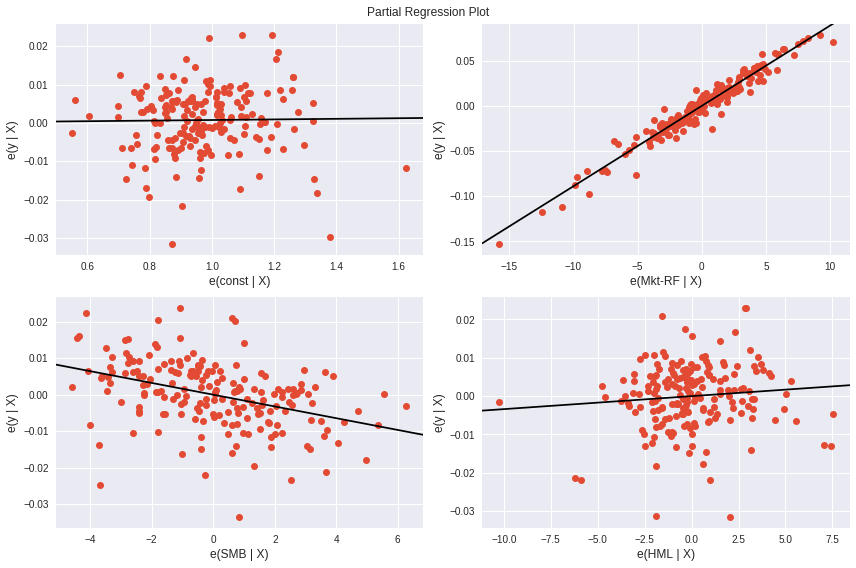

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     1148.
Date:                Mon, 07 May 2018   Prob (F-statistic):          1.39e-120
Time:                        00:45:28   Log-Likelihood:                 646.67
No. Observations:                 192   AIC:                            -1285.
Df Residuals:                     188   BIC:                            -1272.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.260      0.2

In [43]:
# split dependent and independent variable
y_df = df["RP_portfolio_adj"] - df['RF']/100
X_df = df[['Mkt-RF','SMB','HML']]

# Add a constant to the independent value
X1_df = sm.add_constant(X_df)

# make regression model 
model_df = sm.OLS(y_df, X1_df)

# fit model and print results
results_df = model_df.fit()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results_df, fig = fig)
fig.savefig('fama3reg1.png')
plt.show()


print(results_df.summary())
results_df.save("fama3reg.pickle")

### 4.2.2 Alpha and Beta of S&P500 ETF

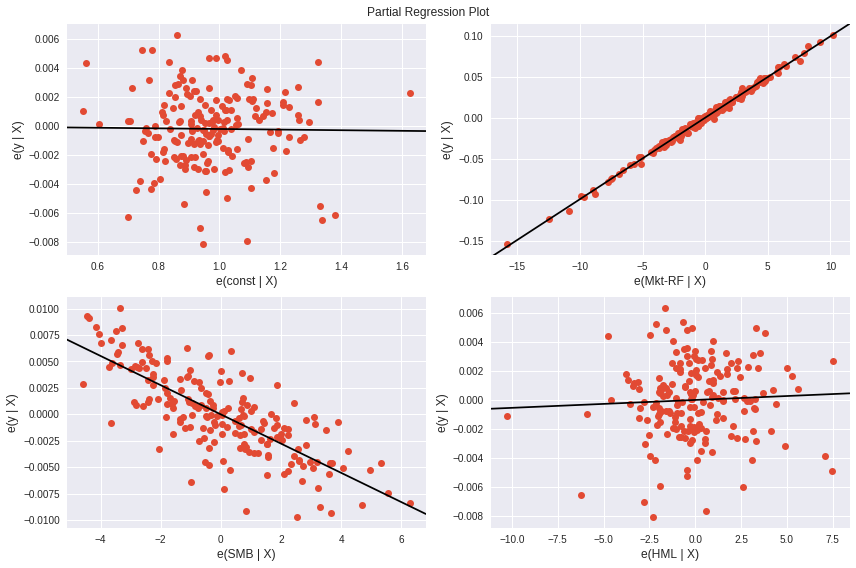

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.538e+04
Date:                Mon, 07 May 2018   Prob (F-statistic):          1.63e-224
Time:                        00:45:08   Log-Likelihood:                 873.76
No. Observations:                 192   AIC:                            -1740.
Df Residuals:                     188   BIC:                            -1726.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.128      0.2

In [42]:
# split dependent and independent variable
y_df = df["SPY"] - df['RF']/100
X_df = df[['Mkt-RF','SMB','HML']]

# Add a constant to the independent value
X1_df = sm.add_constant(X_df)

# make regression model 
model_df = sm.OLS(y_df, X1_df)

# fit model and print results
results_df = model_df.fit()

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(results_df, fig = fig)
plt.show()

print(results_df.summary())

In [0]:
df = df.reset_index()

## 4.3 Monthly Return Pair Plots of S&P500 sectors

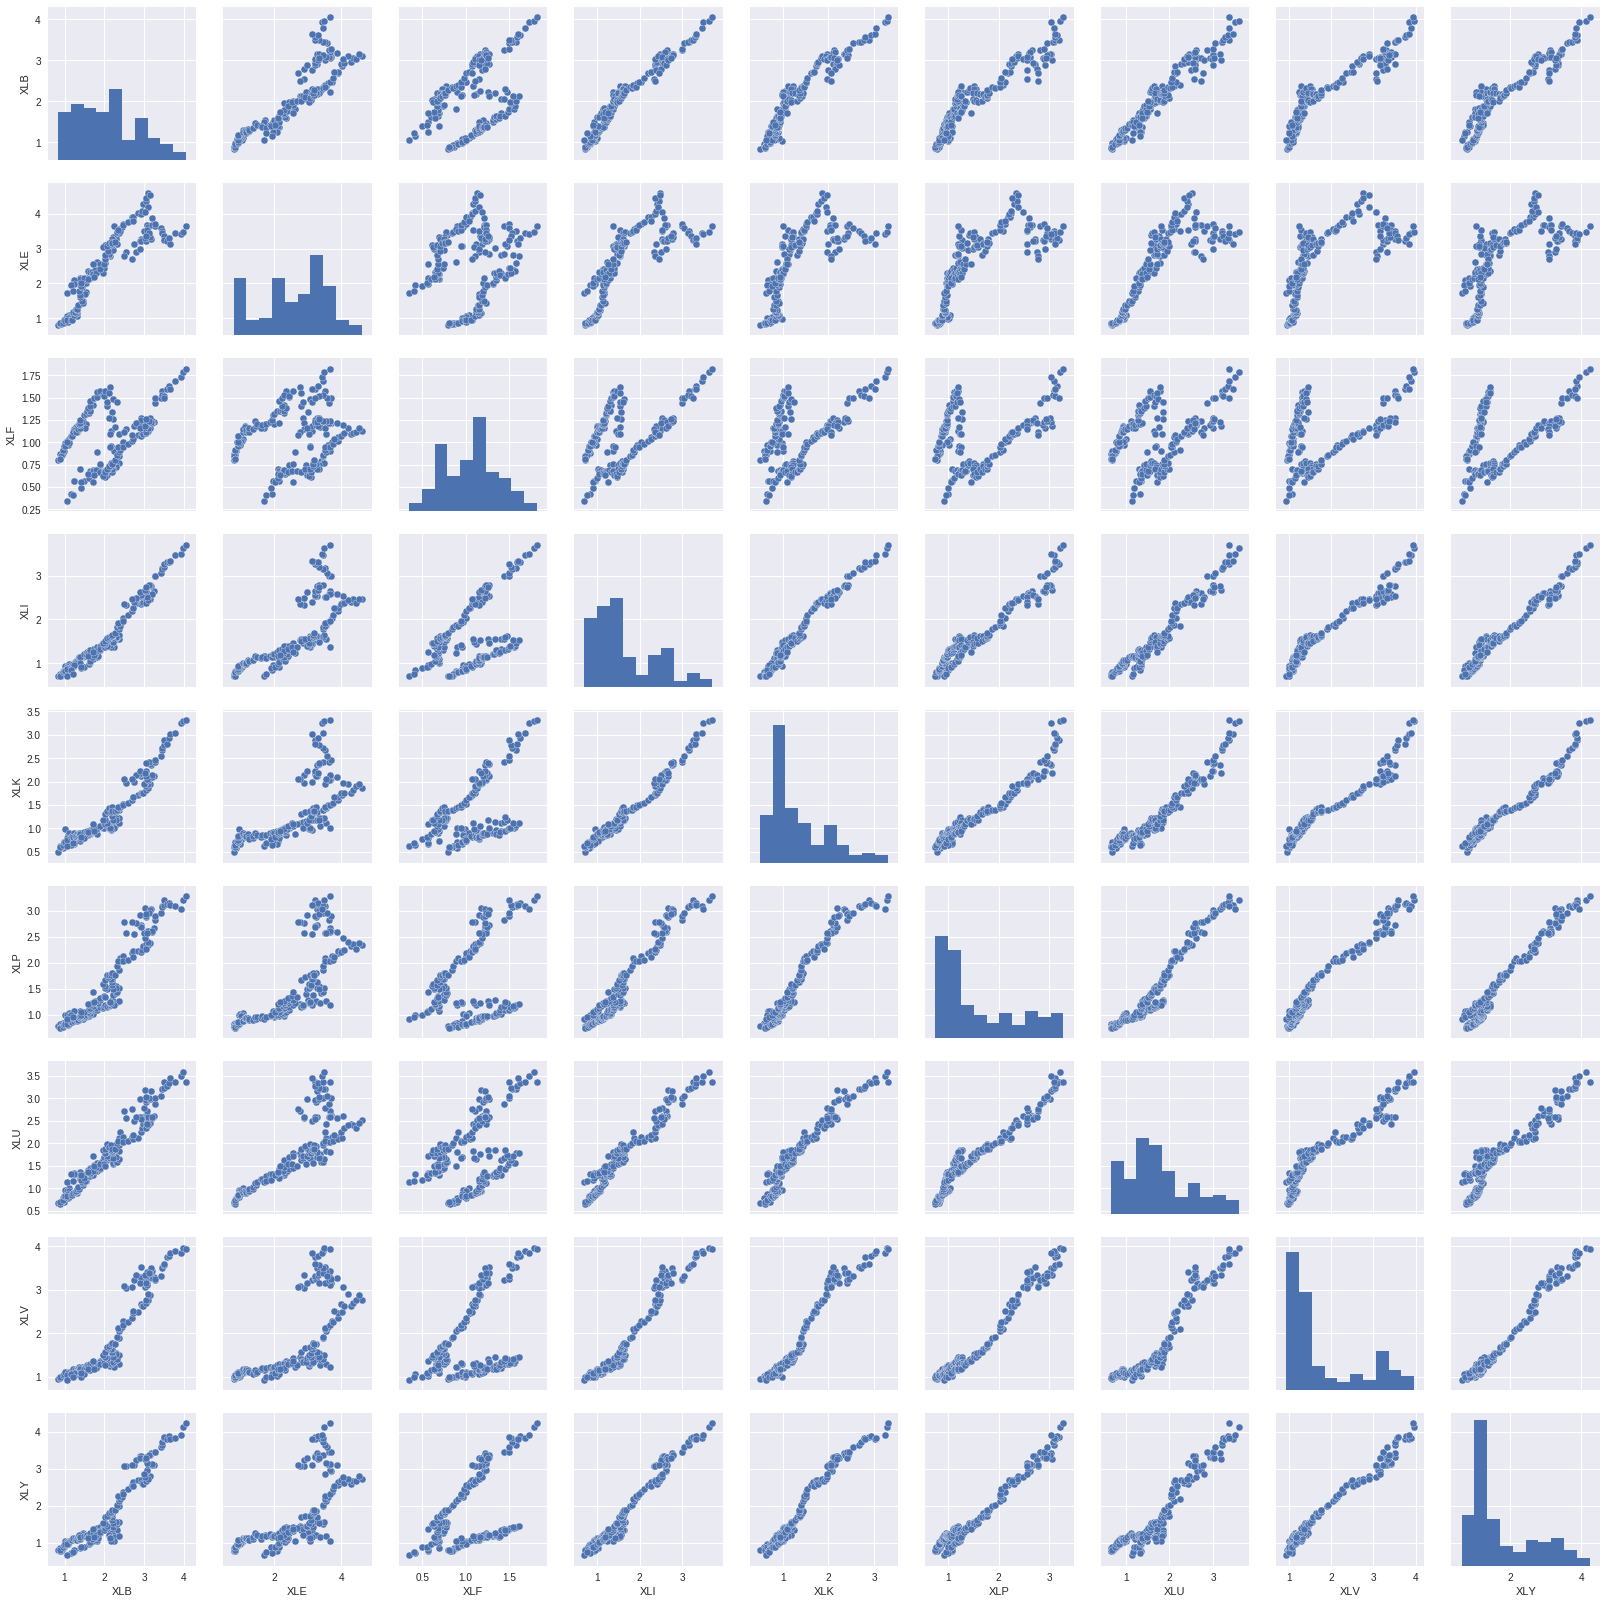

In [56]:
pairplot_tks = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']

sns.set(style='darkgrid')
df_snsM = np.cumprod(1 + df.loc[:, tuple(pairplot_tks)])

sns.pairplot(df_snsM)

## 4.4 RP Portfolio Weight Plots

In [0]:
import vincent

In [0]:
df.head()

,date,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,...,XLU_wt,XLV_wt,XLY_wt,RP_portfolio,weight_diff,RP_portfolio_adj,Mkt-RF,SMB,HML,RF
0,2002-01-01,-0.009799,0.023343,-0.035581,-0.011407,-0.063177,-0.010833,-0.006693,-0.036033,-0.007421,...,0.158681,0.092640,0.090041,-0.013364,0.000000,-0.013364,-1.44,1.19,3.31,0.14
1,2002-02-01,-0.017936,0.052920,0.034175,-0.017308,0.025048,-0.129907,0.021007,-0.001851,0.045981,...,0.157848,0.091487,0.097140,0.006496,0.027290,0.006441,-2.29,-1.10,2.50,0.13
2,2002-03-01,0.033297,0.030725,0.088465,0.066125,0.027125,0.049090,0.016096,0.053162,0.057989,...,0.171826,0.088444,0.092275,0.041023,0.100191,0.040823,4.24,4.24,1.10,0.13
3,2002-04-01,-0.058156,-0.047237,-0.035999,-0.025414,-0.069016,-0.120905,-0.037165,-0.060681,-0.006083,...,0.192901,0.083960,0.100303,-0.044987,0.077985,-0.045143,-5.20,5.94,3.93,0.15
4,2002-05-01,-0.005934,0.049579,-0.017594,-0.003023,0.004337,-0.041470,-0.011142,-0.008311,0.013941,...,0.185980,0.087779,0.102202,-0.003452,0.022997,-0.003498,-1.38,-3.22,1.71,0.14


In [0]:
v_df  = df[['date','XLB_wt', 'XLE_wt', 'XLF_wt', 'XLI_wt', 'XLK_wt', 'XLP_wt', 'XLU_wt', 'XLV_wt', 'XLY_wt']]
v_df= v_df.set_index('date')

In [58]:
v_df.head()

,XLB_wt,XLE_wt,XLF_wt,XLI_wt,XLK_wt,XLP_wt,XLU_wt,XLV_wt,XLY_wt
date,,,,,,,,,
2002-01-01,0.082405,0.108419,0.089559,0.072199,0.085139,0.220917,0.158681,0.092640,0.090041
2002-02-01,0.087986,0.104165,0.089021,0.073164,0.084405,0.214783,0.157848,0.091487,0.097140
2002-03-01,0.084933,0.091094,0.088562,0.066220,0.065745,0.250901,0.171826,0.088444,0.092275
2002-04-01,0.080272,0.088478,0.097978,0.066693,0.061387,0.228027,0.192901,0.083960,0.100303
2002-05-01,0.080320,0.089886,0.101818,0.067178,0.059880,0.224957,0.185980,0.087779,0.102202


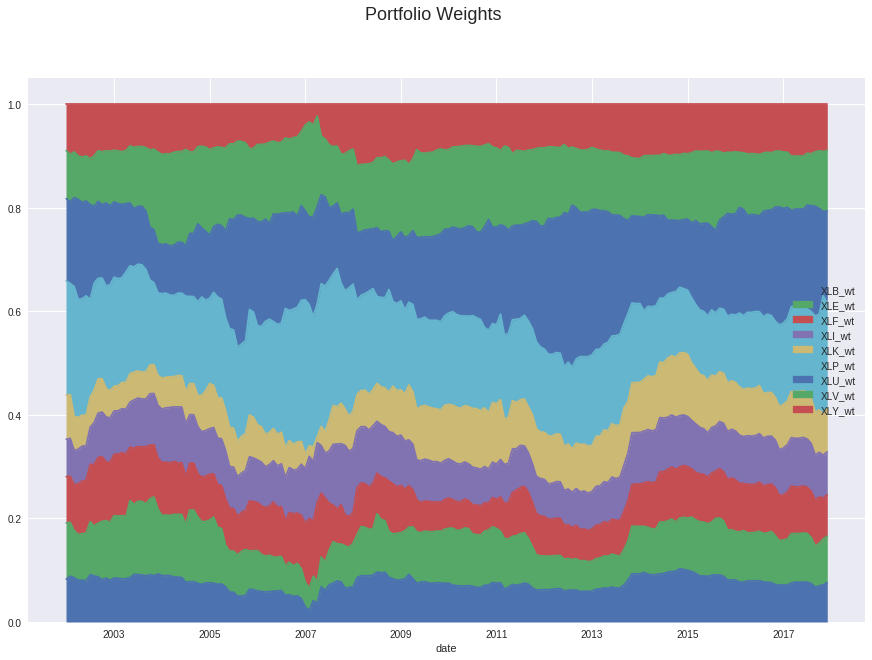

In [59]:
plt.figure()
plt.rcParams['figure.figsize'] = (15,10)
v_df.plot.area()
plt.legend(loc='best')
plt.suptitle('Portfolio Weights', fontsize=18)
axes = plt.plot()
plt.savefig('RPweights1.png')

## 4.5 Cumulative Returns

In [0]:
rt_df = df.loc[:,('date','SPY', 'RP_portfolio_adj')].set_index('date')

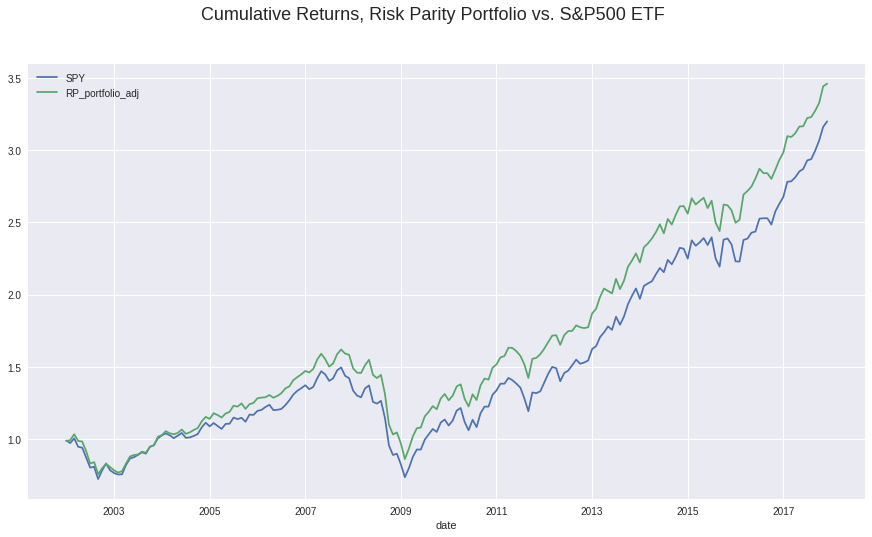

In [61]:
plt.figure()
plt.rcParams['figure.figsize'] = (15, 8)

np.cumprod(1 + rt_df.loc[:, ('SPY', 'RP_portfolio_adj')]).plot()
plt.suptitle('Cumulative Returns, Risk Parity Portfolio vs. S&P500 ETF', fontsize=18)
plt.savefig('Cum_rt.png')
plt.legend()

In [65]:
!pip install monthly_returns_heatmap

  Running setup.py bdist_wheel for monthly-returns-heatmap ... - done
  Stored in directory: /content/.cache/pip/wheels/f0/f6/de/3ba02113d15a27913f325c178a7fc4dcce626f2c7da702cc98
Successfully built monthly-returns-heatmap


In [0]:
import monthly_returns_heatmap as mrh

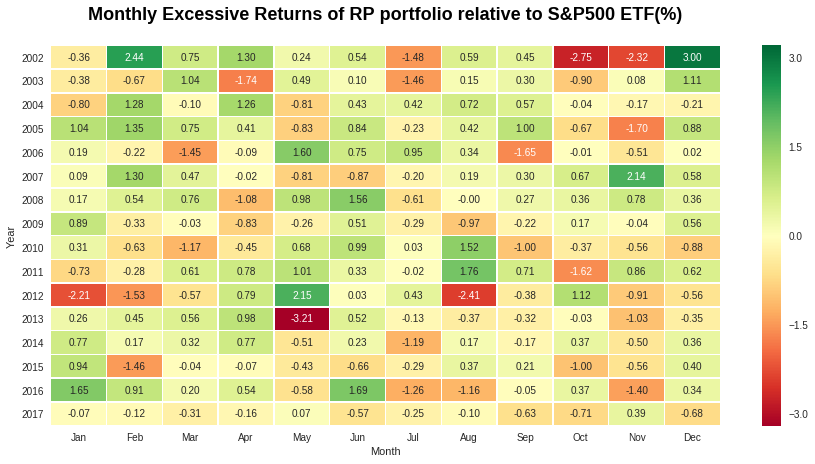

In [67]:
# Green tile is good, Red tile is Bad to RP Portfolio returns
mrh.plot(rt_df.loc[:,('SPY', 'RP_portfolio_adj')].diff(axis=1).RP_portfolio_adj, 
         title='Monthly Excessive Returns of RP portfolio relative to S&P500 ETF(%)\n', title_size=18)

In [0]:
# plot chart deleted

'''
plt.figure()
plt.rcParams['figure.figsize'] = (15, 8)

rt_df.loc[:,('SPY', 'RP_portfolio')].plot()
plt.suptitle('Monthly Excessive Return of Risk Parity Portfolio vs. S&P500 ETF', fontsize=18)
plt.savefig('Mon_rt.png')
plt.legend()

'''

"\nplt.figure()\nplt.rcParams['figure.figsize'] = (15, 8)\n\nrt_df.loc[:,('SPY', 'RP_portfolio')].plot()\nplt.suptitle('Monthly Excessive Return of Risk Parity Portfolio vs. S&P500 ETF', fontsize=18)\nplt.savefig('Mon_rt.png')\nplt.legend()\n\n"

In [0]:
from statsmodels.regression.linear_model import OLSResults
new_results = OLSResults.load("fama3reg.pickle")

In [79]:
print(new_results.summary())

NameError: ignored

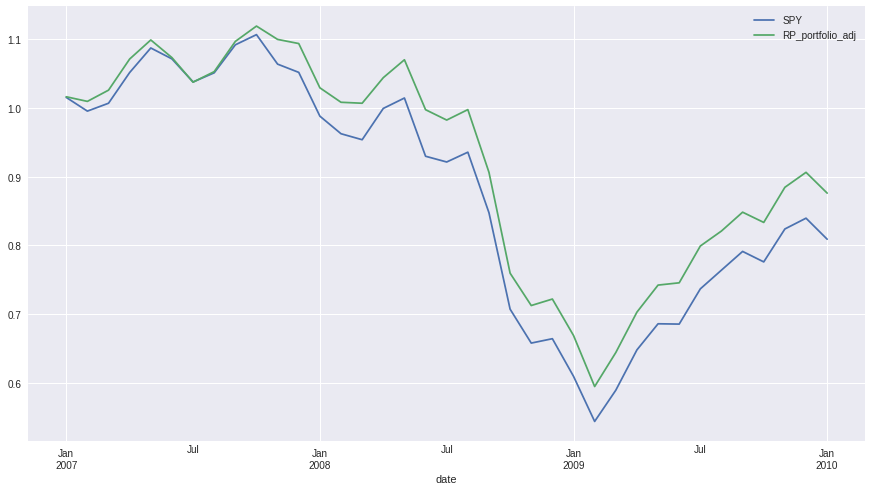

In [70]:
np.cumprod(1 + rt_df.loc['2007-01':'2010-01', ('SPY', 'RP_portfolio_adj')]).plot()
plt.savefig('Cum_crisis.png')

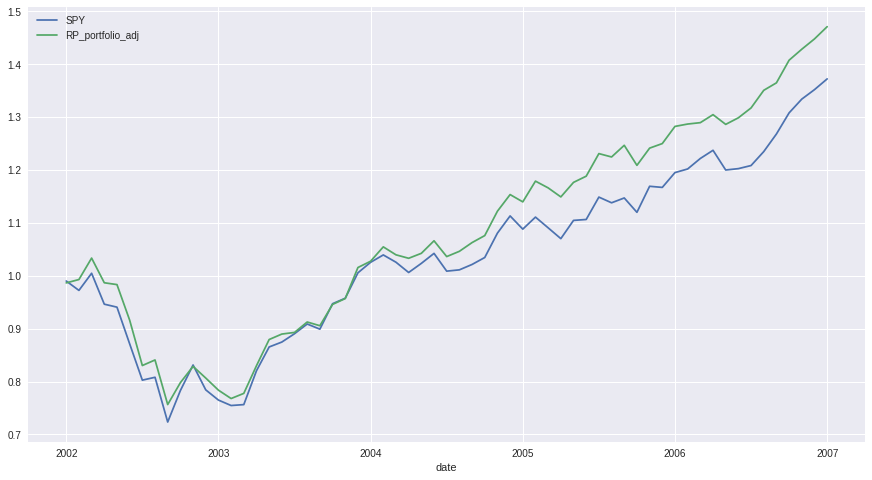

In [71]:
np.cumprod(1 + rt_df.loc['2002-01':'2007-01', ('SPY', 'RP_portfolio_adj')]).plot()
plt.savefig('Cum_first5.png')

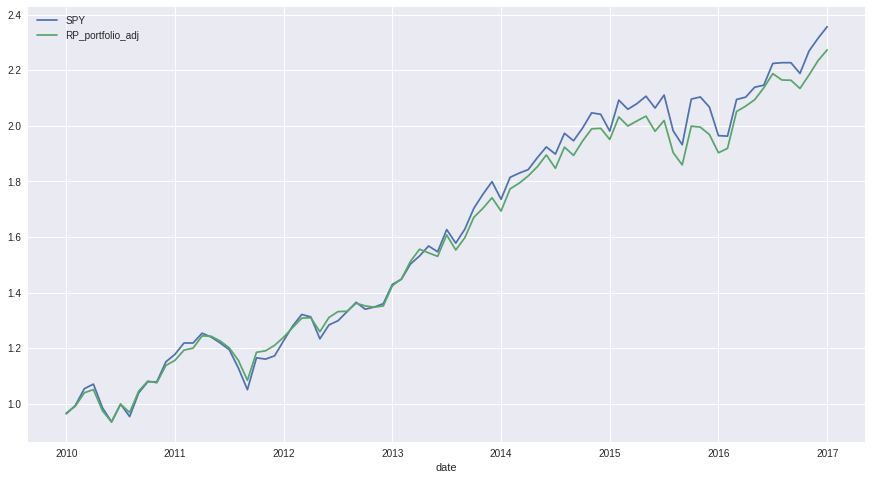

In [72]:
np.cumprod(1 + rt_df.loc['2010-01':'2017-01', ('SPY', 'RP_portfolio_adj')]).plot()
plt.savefig('Cum_last7.png')

In [0]:
#@title Turnover rate


In [0]:
turn_df = df.iloc[:,[10,11,12,13,14,15,16,17,18]]
turn_df = turn_df.stack().reset_index().sort_values(['level_1','date']).set_index(['level_1','date']).rolling(window=2).apply(lambda x: x[1] - x[0])\
  .unstack().iloc[:,1:]

In [125]:
turn_df.head()

0                                                         \
date    2002-02-01 2002-03-01 2002-04-01 2002-05-01 2002-06-01 2002-07-01   
level_1                                                                     
XLB_wt    0.005581  -0.003053  -0.004660   0.000048  -0.001041   0.011655   
XLE_wt   -0.004254  -0.013071  -0.002616   0.001408   0.002362   0.010030   
XLF_wt   -0.000538  -0.000458   0.009416   0.003840  -0.000222   0.009173   
XLI_wt    0.000965  -0.006945   0.000473   0.000485  -0.000318   0.004930   
XLK_wt   -0.000734  -0.018660  -0.004358  -0.001507  -0.000724  -0.001129   

                                                       ...                 \
date    2002-08-01 2002-09-01 2002-10-01 2002-11-01    ...     2017-03-01   
level_1                                                ...                  
XLB_wt   -0.002366  -0.001716  -0.005644   0.003151    ...       0.004406   
XLE_wt   -0.005638   0.007181   0.009000  -0.001684    ...       0.006319   
XLF_wt    0.007822   0.008105  -0.001965  -0.011036    ...       0.000797   
XLI_wt    0.008865   0.004997   0.000716   0.000335    ...       0.002079   
XLK_wt    0.005010   0.003033  -0.001516  -0.009942    ...       0.004371   

                                                                              \
date    2017-04-01    2017-05-01 2017-06-01 2017-07-01 2017-08-01 2017-09-01   
level_1                                                                        
XLB_wt    0.001217 -5.880494e-06   0.000215  -0.000138  -0.002475  -0.006868   
XLE_wt   -0.001116  7.817596e-05   0.000799  -0.000693  -0.005244  -0.009701   
XLF_wt   -0.001525  4.587396e-05   0.000613  -0.001623   0.000090  -0.000101   
XLI_wt    0.000234 -3.038068e-05   0.000029  -0.000661  -0.001023  -0.005398   
XLK_wt    0.001485  7.406840e-07  -0.000235  -0.000366  -0.001289  -0.005855   

                                          
date    2017-10-01 2017-11-01 2017-12-01  
level_1                                   
XLB_wt    0.002414   0.001945   0.004245  
XLE_wt    0.002683   0.006246   0.001421  
XLF_wt    0.000198  -0.009947   0.000497  
XLI_wt   -0.000275  -0.003753   0.000230  
XLK_wt   -0.000566  -0.002363   0.004651  

[5 rows x 191 columns]

In [0]:
turn_df = turn_df.transpose()

In [0]:
turn_df['positive'] = turn_df.sum(axis=1)

In [0]:
turn_df['positive']= turn_df.where(turn_df>0).sum(axis=1)
turn_df['negative']= turn_df.where(turn_df<0).sum(axis=1)

In [0]:
turn_df['turnover'] = turn_df.iloc[:,-2:].max(axis=1)

Text(0.5,1,'Monthly turnover rate')

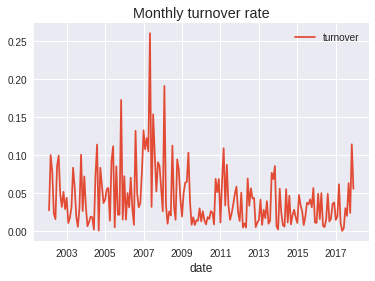

In [163]:
turn_df['turnover'].reset_index().iloc[:,1:].set_index('date').plot()
plt.title('Monthly turnover rate')

In [0]:
yr_turn_df = turn_df['turnover'].reset_index().iloc[:,1:]

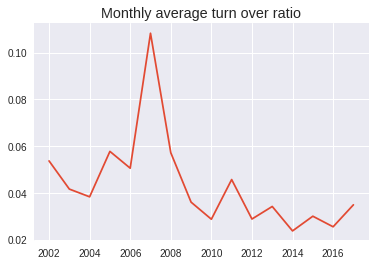

In [185]:
a = yr_turn_df.groupby(yr_turn_df.date.dt.year)['turnover'].transform('mean').drop_duplicates()
plt.title('Monthly average turn over ratio')
plt.plot(yr_turn_df.date.dt.year.unique(),a)

Text(0.5,1,'Yearly turnover rate')

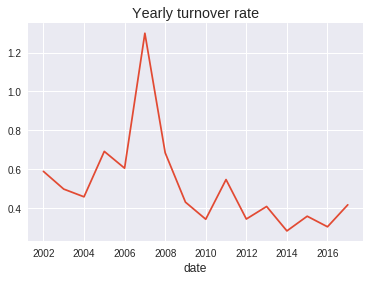

In [166]:
yr_turn_df.groupby(yr_turn_df.date.dt.year)['turnover'].sum().plot()
plt.title('Yearly turnover rate')

In [195]:
print("Turnover rate is\n",yr_turn_df.groupby(yr_turn_df.date.dt.year)['turnover'].sum())

Turnover rate is
 date
2002    0.590222
2003    0.499340
2004    0.459625
2005    0.692655
2006    0.606495
2007    1.298865
2008    0.685759
2009    0.432266
2010    0.344633
2011    0.548182
2012    0.345694
2013    0.410079
2014    0.284694
2015    0.360098
2016    0.305897
2017    0.418600
Name: turnover, dtype: float64
